In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv

import mdpy as mdp

In [2]:
np.set_printoptions(precision=5, suppress=True)

# Bumping w/ Teleportation

The MDP is structured like a hallway where you can either advance or return to the start.
Advancing at the end of the hallway yields a cumulant of 1, and also returns the agent to the start.

In [58]:
# Solve using the matrix formulation
ns = 5
states = np.arange(ns)

I = np.eye(ns)
# transition matrix
p_forward = 0.5
p_backward = 1 - p_forward
P = np.diag(np.ones(ns-1)* p_forward, 1)
P[:,0] = p_backward
P[-1,0] = 1

# expected reward matrix & vector
R = np.zeros((ns, ns))
R[-1][0] = 1*p_forward
rvec = np.sum(P*R, axis=1)

# gamma matrix
gm = np.ones(ns)*0.9
G = np.diag(gm)

In [4]:
P

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0.5],
       [ 1. ,  0. ,  0. ,  0. ,  0. ]])

In [6]:
P @ G

array([[ 0.45,  0.45,  0.  ,  0.  ,  0.  ],
       [ 0.45,  0.  ,  0.45,  0.  ,  0.  ],
       [ 0.45,  0.  ,  0.  ,  0.45,  0.  ],
       [ 0.45,  0.  ,  0.  ,  0.  ,  0.45],
       [ 0.9 ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [7]:
v = pinv(I - P @ G) @ rvec

In [8]:
v

array([ 0.11489,  0.14042,  0.19715,  0.32323,  0.6034 ])

In [11]:
v**2

array([ 0.0132 ,  0.01972,  0.03887,  0.10448,  0.36409])

Define

$$
v(s) = r(s) + \sum_{s'} p(s, s') \gamma(s') v(s')
$$

$$
F_{s} = \sum_{s'} p(s,s') (r(s,s') + \gamma v(s'))^2 - v^2(s)
$$

With the claim that the variance of the return is then

$$
\begin{align}
\operatorname{Var}\left[{G_t| S_t = s}\right] &= \sigma_s = F_s + \gamma^2 \sum_{s'} p(s,s') \sigma_s
\\\\
\vec{\sigma} &= \vec{F} + \gamma^2 P \vec{\sigma}
\\\\
\vec{\sigma} &= (I - \gamma^2 P)^{-1} \vec{F}
\end{align}
$$

In [9]:
v * gm

array([ 0.1034 ,  0.12638,  0.17744,  0.29091,  0.54306])

In [237]:
np.sum(P*(R + G*v)**2, axis=0)

array([ 0.25,  0.  ,  0.  ,  0.  ,  0.  ])

In [22]:
F = -(v**2).reshape(ns, 1)
for (i,j), p in np.ndenumerate(P):
    F[i] += P[i,j] * (R[i,j] + gm[j]*v[j])**2
    
sg = pinv(I - P @ G**2) @ F

In [13]:
F

array([[ 0.00013],
       [ 0.00137],
       [ 0.00879],
       [ 0.04833],
       [ 0.     ]])

In [18]:
# P*(R + G v)

In [17]:
tmp = np.zeros((ns, ns))
for (i,j), p in np.ndenumerate(P):
    tmp[i,j] = P[i,j]*(R[i,j] + gm[j]*v[j])**2
    
(np.sum(tmp, axis=1) - v**2).reshape(ns, 1)

array([[ 0.00013],
       [ 0.00137],
       [ 0.00879],
       [ 0.04833],
       [ 0.     ]])

In [24]:
# tmp

In [20]:
sg

array([[ 0.0169 ],
       [ 0.02451],
       [ 0.04023],
       [ 0.06072],
       [ 0.01369]])

In [25]:
np.linalg.cond((I - P @ G**2))

9.8588122933019271

In [31]:
num_trials = 1000
num_steps = 1000

# Track returns for each trial for each state
ret_mat = np.zeros((num_trials, ns))
viz_mat = np.zeros((num_trials, ns))

for i in range(num_trials):
    # Run simulation
    s = 0
    step_lst = []
    for step in range(num_steps):
        sp = np.random.choice(states, p=P[s])
        reward = R[s, sp]
        step_lst.append([s, reward, sp])
        s = sp

    # Compute discounted return
    ret = 0.0
    for (s, r, sp) in reversed(step_lst):
        ret += r
        
        # Update records
        ret_mat[i, s] += ret
        viz_mat[i, s] += 1
        
        # Prepare for next iteration
        ret *= gm[s]

In [32]:
mc_mat = ret_mat/viz_mat

In [38]:
# Empirical mean
v_exp = np.mean(mc_mat, axis=0)

# Empirical variance
sg_exp = np.var(mc_mat, axis=0)

# Checking via expected mean
sg_check = np.mean(mc_mat**2, axis=0) - v**2

In [42]:
np.abs(v_exp - v)/v

array([ 0.00726,  0.0053 ,  0.0043 ,  0.00443,  0.00544])

The empirical return is accurate to within a percent for 1000 trials of 1000 steps

In [44]:
sg

array([[ 0.0169 ],
       [ 0.02451],
       [ 0.04023],
       [ 0.06072],
       [ 0.01369]])

In [43]:
sg_exp

array([ 0.00031,  0.00045,  0.00085,  0.00175,  0.00059])

In [45]:
np.abs(sg_exp - sg.flat)/sg.flat

array([ 0.98187,  0.98154,  0.97877,  0.97124,  0.95704])

In [46]:
np.abs(sg_exp - sg.flat)/sg_exp.flat

array([ 54.15971,  53.16842,  46.10706,  33.77605,  22.27935])

Conversely, the empirical variance is substantially *lower* than what would be expected.

In [47]:
np.mean(mc_mat**2, axis=0) - np.mean(mc_mat, axis=0)**2

array([ 0.00031,  0.00045,  0.00085,  0.00175,  0.00059])

In [55]:
np.var(ret_mat**2/, axis=0)

array([ 960393.65913,  143906.61574,   43140.17153,   23447.11141,
         19333.70885])

In [48]:
mc_mat[:10]

array([[ 0.12098,  0.14648,  0.20835,  0.34169,  0.60303],
       [ 0.11937,  0.13807,  0.183  ,  0.31069,  0.58838],
       [ 0.12503,  0.1545 ,  0.22448,  0.39174,  0.62046],
       [ 0.11443,  0.14572,  0.20153,  0.34914,  0.59926],
       [ 0.11649,  0.15045,  0.20998,  0.36076,  0.6175 ],
       [ 0.09828,  0.12196,  0.17196,  0.28252,  0.58073],
       [ 0.13069,  0.17052,  0.22825,  0.37916,  0.65146],
       [ 0.09942,  0.12135,  0.1623 ,  0.2869 ,  0.59418],
       [ 0.12387,  0.14784,  0.22946,  0.34781,  0.60667],
       [ 0.11098,  0.13448,  0.1886 ,  0.29069,  0.59088]])

<Container object of 5 artists>

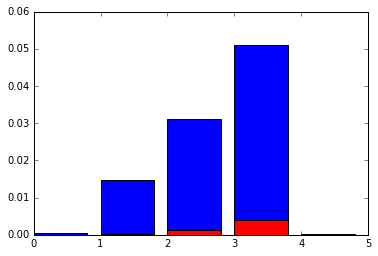

In [232]:
plt.bar(states, sg)
plt.bar(states, sg_exp, color='red')

<Container object of 5 artists>

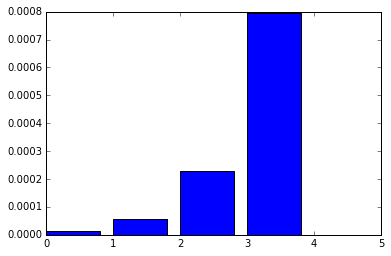

In [149]:
plt.bar(states, sg_exp)

In [145]:
v_exp

array([ 0.02052859,  0.04559857,  0.10127524,  0.22548427,  0.5       ])

In [146]:
v - v_exp

array([ -2.54605310e-05,  -3.60656976e-05,  -2.52444900e-05,
        -4.84273832e-04,   2.22044605e-16])